**IMPORTANT** <br> <ul> <li> Do **NOT** replace or remove this notebook (ipynb file)! Each cell has unique nbgrader's metadata and ID which, if changed outside the nbgrader, cannot pass the tests. Do **NOT** change the name of the file!</li> <li> To receive any credit, don't forget to **SUBMIT** your notebook when you are done! You can have multiple submissions before the deadline; only the last one is saved, including its timestamp.</li> <li>Before submitting, **Validate** your notebook to check if your codes pass all visible tests. </li> <li>Make sure you fill in any cell with the comment `# your code here`. Remove or comment the command `fail()` (in R), or `raise NotImplementedError` (in Python) and place your code there </li> </ul>

In [1]:
NAME = "Madison Chester"

---

In [2]:
## import libraries needed
## make sure you run this code first!

library(testthat)
library(digest)
library(stringr)

## Question 1.

Recall that in HW1 we've seen predicting whether a person has heart disease or not, based on 14 variables/predictors. We used Naive Bayes method in Python. This time, we will use logistic regression in R.

The dataset we used can be found at <https://www.statlearning.com> as Heart.csv file. 

Before loading the dataset, we first import libraries needed for this assignment. To do that, run the following cell and take a look at which libraries we use.

In [3]:

library(glmnet) #to do logistic regression with regularization
library(latex2exp) #used for including some latex in plots
library(pROC) #used for plotting ROC curve


Loading required package: Matrix

Loaded glmnet 4.1-3

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var





### Importing and Cleaning Data


<br>


We now load the dataset stored in the same folder as this notebook. Take a look at the first couple of obs, and variables. Our output variable will be the last one, `AHD`, which is a binary variable (Yes/No), and which indicates the presence of a heart disease based on the **A**ngiographic **H**eart **D**isease test. 

Our goal is to predict the value of `AHD` (Yes or No) based on all the other variables.

In [4]:

heart = read.csv("Heart.csv")
head(heart)
dim(heart)



,PatientID,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
,<int>,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<fct>,<fct>
1,1,63,1,typical,145,233,1,2,150,0,2.3,3,0,fixed,No
2,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3,normal,Yes
3,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2,reversable,Yes
4,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0,normal,No
5,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0,normal,No
6,6,56,1,nontypical,120,236,0,0,178,0,0.8,1,0,normal,No


[1] 303  15

Our R data frame object `heart` has some missing values, although only 6. Run the following code to see that.

In [5]:
sum(is.na(heart))

[1] 6

We will drop the observations (rows) that contain missing data.

<br>

### Part (a)

<br>


Change the data frame `heart` by dropping/omitting the rows with missing values (use the same name "heart" for the modified data frame). So, your code should be of the form

`heart = <some expression>`

<br>

The modified `heart` dataframe should have 297 rows/obs. 

In [6]:
heart = na.omit(heart)
head(heart) #sanity check

,PatientID,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
,<int>,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<fct>,<fct>
1,1,63,1,typical,145,233,1,2,150,0,2.3,3,0,fixed,No
2,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3,normal,Yes
3,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2,reversable,Yes
4,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0,normal,No
5,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0,normal,No
6,6,56,1,nontypical,120,236,0,0,178,0,0.8,1,0,normal,No


In [7]:
## check whether heart is a data frame and of correct dimensions

if (test_that(desc="", code={
    expect_equal(is.data.frame(heart), TRUE)
    }) != TRUE) stop("Sorry, wrong answer")

if (test_that(desc="", code={
    expect_equal(dim(heart), c(297,15))
    }) != TRUE) stop("Sorry, wrong dimensions of the data frame heart")


Test passed 🎉
Test passed 🥳


### Train-Test Split

Next, we split our dataset into training and testing data at the ration 70/30. These two new data frame will be called `train` and `test`. 

To make sure everyone is on the same page, we set the seed (to 1234) before randomly choose 70% of the data as training data.



In [8]:
set.seed(1234)
trainidx = sample(1:nrow(heart),size=0.7*nrow(heart),replace=FALSE)


train = heart[trainidx, ]
test = heart[-trainidx, ]

dim(train) #see the dimensions of train data frame

#check the proportions 70%-30% of data taken into the train and test data frames
noquote(paste("proportion of train data:",nrow(train)/nrow(heart)))
noquote(paste("proportion of test data:",nrow(test)/nrow(heart)))

[1] 207  15

[1] proportion of train data: 0.696969696969697

[1] proportion of test data: 0.303030303030303

In [9]:

#get response vector y and predictor matrix (in fact, data frame) X from heart data
y = train$AHD
X = train[ ,!(names(train) %in% c("PatientID","AHD"))] #all but PatientID and AHD
dim(X)

[1] 207  13

## Preprocessing Categorical Predictors

<br>

Our predictor matrix `X` is actually an R data frame. In order to use it in the `cv.glmnet()` function from `glmnet` library, we should convert it into an R matrix object. Furthermore, the function `cv.glmnet()` does not take care of categorical variables (by creating dummies) automatically. So, we need to preprocess categorical variables and code the levels into dummy variables.

By running the following code, you see that `ChestPain` and `Thal` are categorical variables, having 4 and 3 levels (i.e. categories), respectively.


In [10]:
str(X) #structure of X

'data.frame':	207 obs. of  13 variables:
 $ Age      : int  56 34 56 51 52 71 46 66 48 71 ...
 $ Sex      : int  1 1 1 1 1 0 0 1 1 0 ...
 $ ChestPain: Factor w/ 4 levels "asymptomatic",..: 3 4 1 1 3 2 3 1 3 1 ...
 $ RestBP   : int  130 118 125 140 134 110 105 120 130 112 ...
 $ Chol     : int  221 182 249 261 201 265 204 302 245 149 ...
 $ Fbs      : int  0 0 1 0 0 1 0 0 0 0 ...
 $ RestECG  : int  2 2 2 2 0 2 0 2 2 0 ...
 $ MaxHR    : int  163 174 144 186 158 130 172 151 180 125 ...
 $ ExAng    : int  0 0 1 1 0 0 0 0 0 0 ...
 $ Oldpeak  : num  0 0 1.2 0 0.8 0 0 0.4 0.2 1.6 ...
 $ Slope    : int  1 1 2 1 1 1 1 2 2 2 ...
 $ Ca       : int  0 0 1 0 1 1 0 0 0 0 ...
 $ Thal     : Factor w/ 3 levels "fixed","normal",..: 3 2 2 2 2 2 2 2 2 2 ...


To dummy up our categorical variables, we only need one line of code:

`X = model.matrix( ~ . , data=X)[,-1]`

By having `[,-1]` at the end we are dropping the first column of `model.matrix( ~ . , data=X)`, which is the column of 1's (for the intercept). Function `cv.glmnet()` needs matrix of predictors only, i.e. without 1's. 

In [11]:
X = model.matrix( ~ . , data=X)[,-1]

dim(X)

X[1:5,]

[1] 207  16

,Age,Sex,ChestPainnonanginal,ChestPainnontypical,ChestPaintypical,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thalnormal,Thalreversable
289,56,1,0,1,0,130,221,0,2,163,0,0.0,1,0,0,1
102,34,1,0,0,1,118,182,0,2,174,0,0.0,1,0,1,0
112,56,1,0,0,0,125,249,1,2,144,1,1.2,2,1,1,0
134,51,1,0,0,0,140,261,0,2,186,1,0.0,1,0,1,0
99,52,1,0,1,0,134,201,0,0,158,0,0.8,1,1,1,0


Note that there are 3 dummies for the 4-level variable `ChestPain`. The level `asymptomatic` does not need a dummy, if we dummy up the other three levels. As discussed in class, this is because when the sum of the three dummies is 0 (i.e. `ChestPain` value is neither of the three levels), that indicates the corresponding observation has level `asymptomatic`. Note also that the names of all dummies are concatenation of the name of the variable (`ChestPain`) and the corresponding level.

Similarly, variable `Thal` which has 3 levels was dummied up by 2 dummies. Consequently, instead of 13 columns, we now have 16.

By the way, we could also use one-hot coding, where for each level of a catogorical variable we have a corresponding indicator variable, with 1 if the observation has that level, and 0 otherwise. However, the dummy encoding used above has one dummy variable less for each categorical variable, than one-hot encoding. The extra dummy variable is redundant, although the one-hot encoding is a bit more readable.



### Ridge Regularization

<br>


To fit the model, we use cross-validation to tune the hyperparameter $\lambda$. For that purpose, we deploy the function `cv.glmnet()` from the library `glmnet`.

<br>

We will use both **deviance** $D = -2\ln L(\beta)=2\ell(\beta)$  (common for logistic regression), and **mean squared error** $MSE = \sum_i(y_i-\hat{y}_i)^2$ as measures of goodness of fit.


**Note**: In logistic regression (i.e. when the only values of the output are 0-1), we have that $\forall i, \,\,(y_i-\hat{y}_i)^2\in\{0,1\}$. So, $MSE$ = 1 - accuracy.

Also, we will set the grid for lambda manually, rather than letting the function `cv.glmnet()` to decide for us. One should be cautions when setting the lambda grid manually, as sometimes that may lead to issues with convergence of the algorithm; also, it is less efficient. For more details, see the documentation for `cv.glmnet()`. The only reason for setting lambda grid manually here is so that the plots are a bit nicer.

<br>

**Run the following cells and study the codes/commands and their outputs, as well as the comments that preceed the commands. The comments are explanations of the commands, and some of them are also hints for the parts that you need to do.**

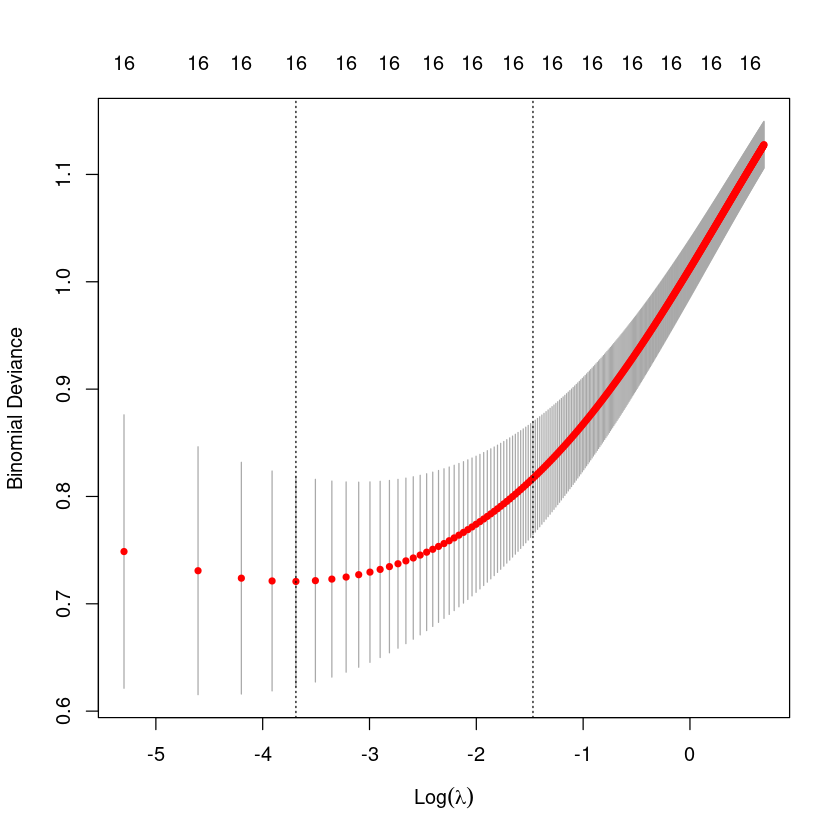

In [12]:
#setting lambda grid manually
mylambda=seq(0,2,by=0.005) 

#Here, we use deviance as a measure performance.

#by default, for logistic regression, type.measure is "deviance"
cvfit = cv.glmnet(X,y,family = "binomial",lambda=mylambda,type.measure="deviance",
                  nfolds = 10, alpha = 0)  #alpha- ridge:0, lasso:1
#plot Ridge based on deviance
plot(cvfit)  #note on x-axis in the plot is log(lambda), not log(1/lambda)


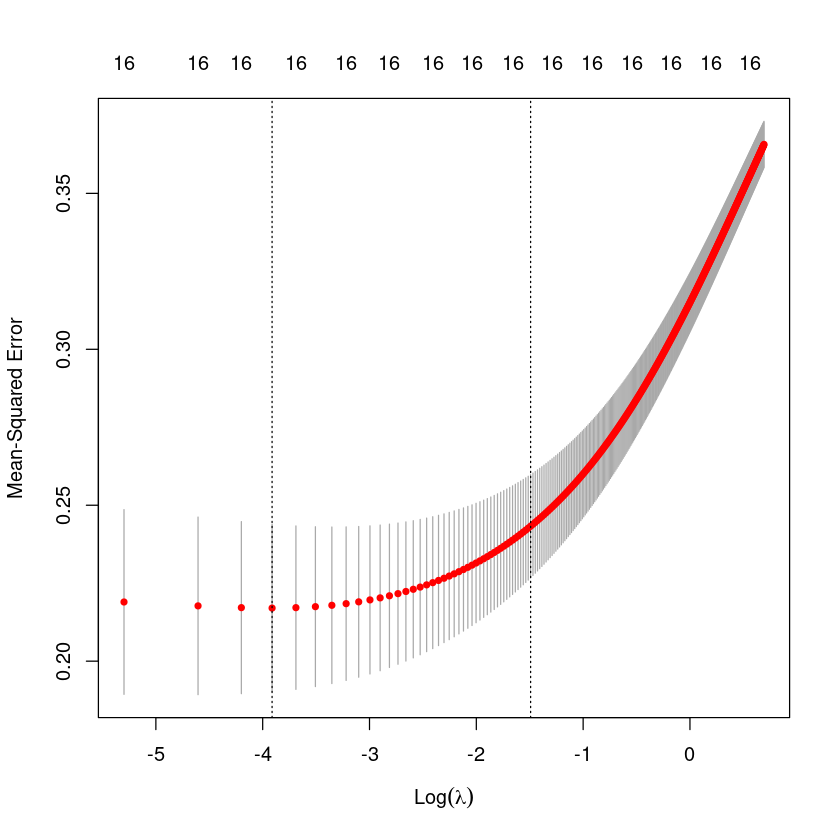

In [13]:
#Here, we use MSE as a measure of performance. 

#by default, for logistic regression, type.measure is "deviance"
cvfit = cv.glmnet(X,y,family = "binomial",lambda=mylambda, type.measure="mse",
                  nfolds = 10, alpha = 0)  #alpha- ridge:0, lasso:1
#plot Ridge based on mse
plot(cvfit)  #note on x-axis in the plot is log(lambda), not log(1/lambda)



In [14]:
#exploring the structure of the object cvfit
str(cvfit)

List of 12
 $ lambda    : num [1:401] 2 2 1.99 1.99 1.98 ...
 $ cvm       : num [1:401] 0.366 0.365 0.365 0.365 0.365 ...
 $ cvsd      : num [1:401] 0.0074 0.00741 0.00741 0.00742 0.00742 ...
 $ cvup      : num [1:401] 0.373 0.373 0.373 0.373 0.372 ...
 $ cvlo      : num [1:401] 0.358 0.358 0.358 0.358 0.358 ...
 $ nzero     : Named int [1:401] 16 16 16 16 16 16 16 16 16 16 ...
  ..- attr(*, "names")= chr [1:401] "s0" "s1" "s2" "s3" ...
 $ call      : language cv.glmnet(x = X, y = y, lambda = mylambda, type.measure = "mse", nfolds = 10,      family = "binomial", alpha = 0)
 $ name      : Named chr "Mean-Squared Error"
  ..- attr(*, "names")= chr "mse"
 $ glmnet.fit:List of 13
  ..$ a0        : Named num [1:401] -0.643 -0.644 -0.645 -0.646 -0.647 ...
  .. ..- attr(*, "names")= chr [1:401] "s0" "s1" "s2" "s3" ...
  ..$ beta      :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. ..@ i       : int [1:6416] 0 1 2 3 4 5 6 7 8 9 ...
  .. .. ..@ p       : int [1:402] 0 16 32 48

In [15]:
#the value of optimal lambda that minimizes loss (we used mse)
cvfit$lambda.min

#the value of optimal lambda by the 1SE rule
cvfit$lambda.1se

[1] 0.02

[1] 0.225

#### Fitted Coefficients

<br>

We can use either `coef(cvfit)` or `predict(object=cvfit, type="coefficients")` to see the values of all the fitted coefficients. We also check they give the same values.

In [16]:
noquote("Using coef(cvfit):") # print() prints out with quotes, noquote() doesn't
coef(cvfit)

cat("\n\n") #making two lines of space

noquote('Using predict(object=cvfit, type="coefficients"):')
predict(object=cvfit, type="coefficients")



[1] Using coef(cvfit):

17 x 1 sparse Matrix of class "dgCMatrix"
                              s1
(Intercept)         -1.782448114
Age                  0.013372278
Sex                  0.394395928
ChestPainnonanginal -0.487454045
ChestPainnontypical -0.290608142
ChestPaintypical    -0.861752467
RestBP               0.005797423
Chol                 0.001795293
Fbs                 -0.175199014
RestECG              0.078656813
MaxHR               -0.009349037
ExAng                0.387894541
Oldpeak              0.192887448
Slope                0.275468856
Ca                   0.412150914
Thalnormal          -0.489966592
Thalreversable       0.583660852

[1] Using predict(object=cvfit, type="coefficients"):

17 x 1 sparse Matrix of class "dgCMatrix"
                      lambda.1se
(Intercept)         -1.782448114
Age                  0.013372278
Sex                  0.394395928
ChestPainnonanginal -0.487454045
ChestPainnontypical -0.290608142
ChestPaintypical    -0.861752467
RestBP               0.005797423
Chol                 0.001795293
Fbs                 -0.175199014
RestECG              0.078656813
MaxHR               -0.009349037
ExAng                0.387894541
Oldpeak              0.192887448
Slope                0.275468856
Ca                   0.412150914
Thalnormal          -0.489966592
Thalreversable       0.583660852

In [17]:
#check that all the coefficients are the same

all(coef(cvfit)==predict(object=cvfit, type="coefficients"))

[1] TRUE

Note that in the output `predict()` we see the fitted values correspond to optimal $\lambda$ based on the 1SE rule, which `coef()` function also gives as a default.

There is a parameter `s` in the `predict()` function that controls which lambda we want. According to what we just saw, the default $\lambda$ is the one based on the 1SE rule. In other words,

`predict(object=cvfit, s=cvfit$lambda.1se, type="coefficients")` 

gives the same output as 

`predict(object=cvfit, type="coefficients")` or as `coef(cvfit)`.

You can check that by running the following cell.

In [18]:
all(predict(object=cvfit, s=cvfit$lambda.1se, type="coefficients") == predict(object=cvfit, type="coefficients"))

[1] TRUE

### Predicting on Test Data

<br>

To check performance, we use `predict()` function and include the argument `newx`, which is the predictor matrix with the test data (not used for tuning the hyperparameter $\lambda$ and fitting the model).

In [19]:
ytest = test$AHD
Xtest = test[ ,!(names(test) %in% c("PatientID","AHD"))] #all but PatientID and AHD

Xtest = model.matrix( ~ ., data=Xtest)[,-1]
pihat = predict(object=cvfit, newx = Xtest, type="response")

length(pihat)
dim(Xtest)


[1] 90

[1] 90 16

### Measuring Performance

<br>

We will assess performance using ROC curve and accuracy, as well as false negative rate (since we don't want our model to false predict no heart disease when it does occur).

<br> <br>

#### ROC Curve


<br>

Setting levels: control = FALSE, case = TRUE

Warning message in roc.default(response = ylogical, predictor = pihat):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



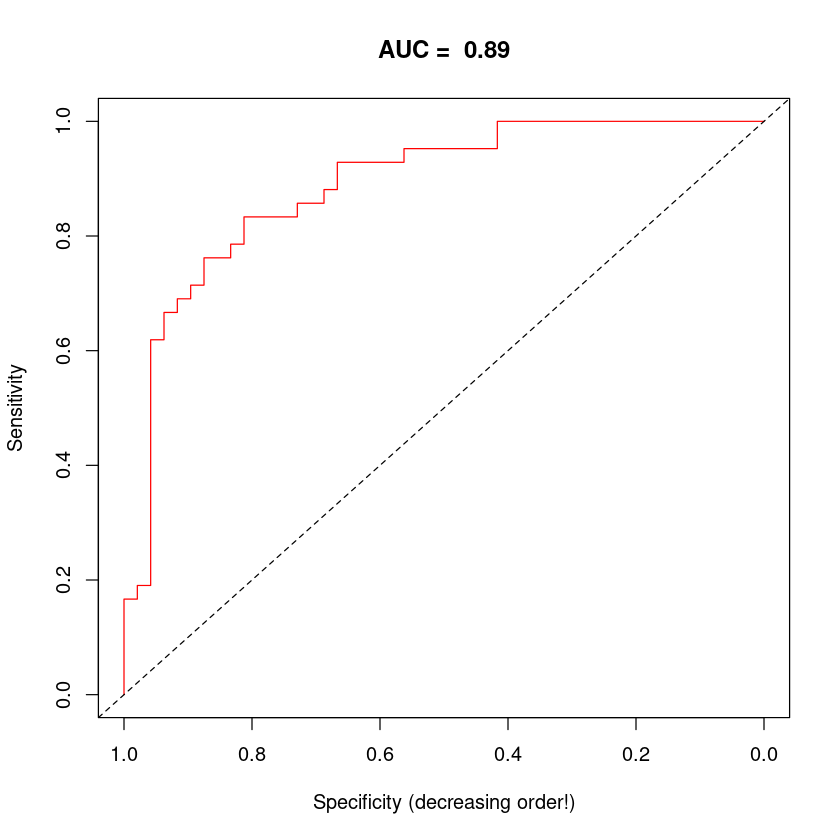

In [20]:
ylogical = (ytest == "Yes")
ROCcrv = roc(response=ylogical, predictor=pihat)
AUC = auc(ROCcrv)

plot(x=ROCcrv$specificities,y=ROCcrv$sensitivities, main=paste("AUC = ",round(AUC,2)), 
     xlab="Specificity (decreasing order!)", ylab="Sensitivity", xlim=c(1,0), type="l", col="red")
abline(a=1,b=-1,lty="dashed") #the diagonal line


In [21]:
#explore the structure of AUC object, produced by the function auc()
#note that it is a numeric variable, a single value, but with a lot of attributes (i.e. info behind this single value)
str(AUC)

 'auc' num 0.887
 - attr(*, "partial.auc")= logi FALSE
 - attr(*, "percent")= logi FALSE
 - attr(*, "roc")=List of 15
  ..$ percent           : logi FALSE
  ..$ sensitivities     : num [1:91] 1 1 1 1 1 1 1 1 1 1 ...
  ..$ specificities     : num [1:91] 0 0.0208 0.0417 0.0625 0.0833 ...
  ..$ thresholds        : num [1:91] -Inf 0.109 0.119 0.123 0.127 ...
  ..$ direction         : chr "<"
  ..$ cases             : num [1:42] 0.888 0.552 0.348 0.713 0.764 ...
  ..$ controls          : num [1:48] 0.426 0.142 0.336 0.186 0.118 ...
  ..$ fun.sesp          :function (thresholds, controls, cases, direction)  
  ..$ auc               : 'auc' num 0.887
  .. ..- attr(*, "partial.auc")= logi FALSE
  .. ..- attr(*, "percent")= logi FALSE
  .. ..- attr(*, "roc")=List of 15
  .. .. ..$ percent           : logi FALSE
  .. .. ..$ sensitivities     : num [1:91] 1 1 1 1 1 1 1 1 1 1 ...
  .. .. ..$ specificities     : num [1:91] 0 0.0208 0.0417 0.0625 0.0833 ...
  .. .. ..$ thresholds        : num [1:91]

In [22]:
#print the precise value of AUC
AUC

Area under the curve: 0.8874

In [23]:
#creating yhat vector based on the rule: yhat=Yes if pihat>0.5; otherwise, yhat=No

yhat = ifelse(pihat>0.5,"Yes","No")

In [24]:
tbl = table(yhat, ytest)
tbl

     ytest
yhat  No Yes
  No  41  10
  Yes  7  32

In [25]:
#accuracy (proportion of correctly predicted)

(tbl[1,1]+tbl[2,2])/sum(tbl)

[1] 0.8111111

In [26]:
#false negative rate

tbl[1,2]/sum(tbl[,2])

[1] 0.2380952

If you check HW1, you will see that Naive Bayes model slightly beats the logistic regression model with regularization, done here. However, if we change a seed that randomly creates the train-test split, we would get slightly different (or maybe more significantly different) results. One could take numerous seeds, produce the results as done here and in HW1, compare them for each train-test split, and see in how many splits each method won. That would be fun &#128512;.

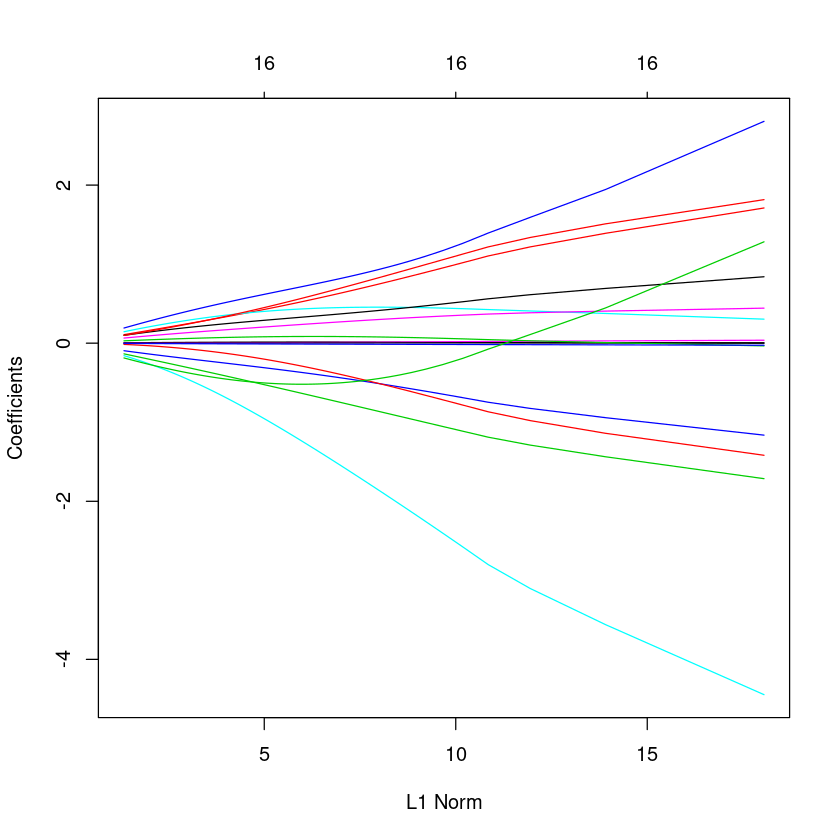

In [27]:
#beta coefficients for various models, i.e. various lambdas/flexibilities
plot(cvfit$glmnet.fit)

<br>

### Lasso Regularization


<br>

Now it's your turn to repeat some of the above steps, but for lasso regularization.

<br>

### Part (b)

Fit the lasso model using cross-validation with 10 folds. To do that, create object `cvfit` using `cv.glmnet()` function. Use **deviance** as a loss function, i.e. as a measure of performance. Also, use the `mylambda` as the vector of $\lambda$'s.

If everything is okay, the estimated intercept coefficient should be -0.107011809; also variable Age does not appear in the model with optimal $\lambda$ based on the 1SE rule. 

**IMPORTANT!** 
Due to some weird relation between `cv.glmnet()` and `coef()`functions, rerunning the command `cvfit = cv.glmnet(...)` followed by `coef(cvfit)` will change the object `coef(cvfit)` output. To rerun `cvfit = cv.glmnet()` after you ran `coef(cvfit)`, you should restart the Kernel, using the Kernel tab on the top of the jupyter notebook. Very weird!

This means that the aforementioned estimated intercept coefficient should be -0.107011809 only if you run `cv.glmnet(...)` and then `coef(cvfit)` once. You can, however, rerun `cvfit = cv.glmnet()` multiple times, as long as you don't also run `coef(cvfit)` before running again`cvfit = cv.glmnet()`. 


In [28]:
cvfit <- cv.glmnet(X, y, family = "binomial", lambda = mylambda, nfolds = 10, alpha = 1)

In [29]:
#as mentioned above, after running this command, if you want 
#to rerun the above cvfit code, restart Kernel first!!!
coef(cvfit)

17 x 1 sparse Matrix of class "dgCMatrix"
                              s1
(Intercept)         -0.107011809
Age                  .          
Sex                  0.200615060
ChestPainnonanginal -0.514126558
ChestPainnontypical  .          
ChestPaintypical    -1.125311393
RestBP               0.001591773
Chol                 .          
Fbs                  .          
RestECG              .          
MaxHR               -0.013276988
ExAng                0.354603158
Oldpeak              0.317196918
Slope                0.196674805
Ca                   0.810135245
Thalnormal           .          
Thalreversable       1.359537640

In [30]:
#check whether the intercept coefficient is -0.107011809234714

if (test_that(desc="", code={
    expect_equal(abs(coef(cvfit)[1] - (-0.107011809234714)) < 1.e-6, TRUE)
    }) != TRUE) stop("Sorry, wrong answer")

Test passed 🎊


In [31]:
#check whether the Age variable does not appear in the cvfit model (i.e. its coef. is 0) 

if (test_that(desc="", code={
    expect_equal(coef(cvfit)[2], 0)
    }) != TRUE) stop("Sorry, wrong answer")


#check also the 3rd, 6th and 7th coefficient
if (test_that(desc="", code={
    expect_equal(norm(coef(cvfit)[c(3,6,7)] - c(0.200615060,-1.125311393,0.001591773),type="2") < 1.e-5, TRUE)
    }) != TRUE) stop("Sorry, wrong answer")


Test passed 😸
Test passed 😀


In [32]:
#check whether cvfit is correct (hidden tests)



Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”


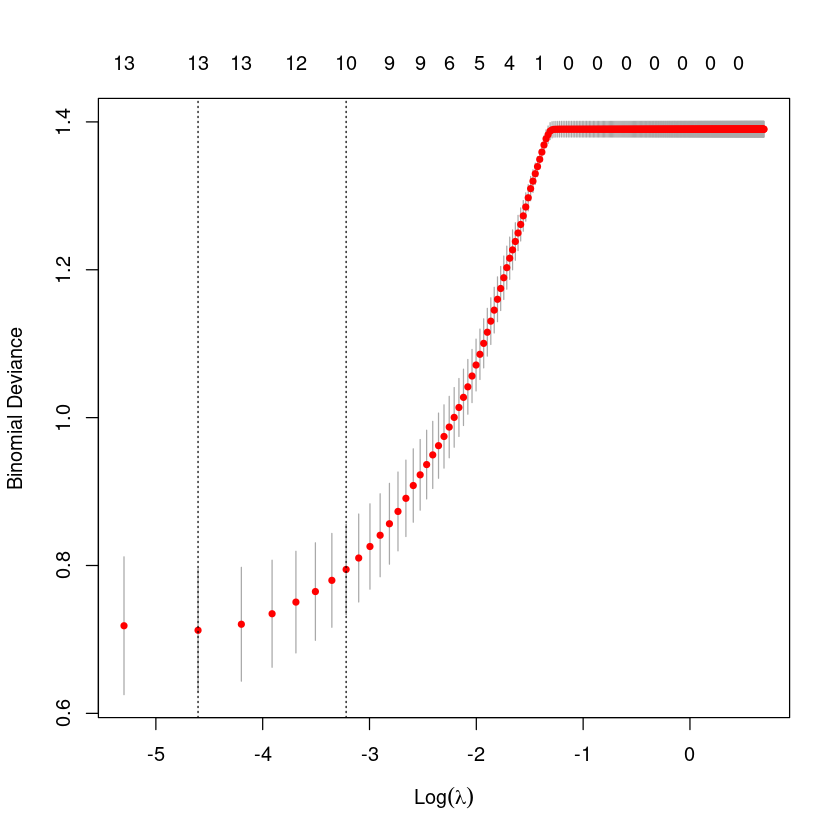

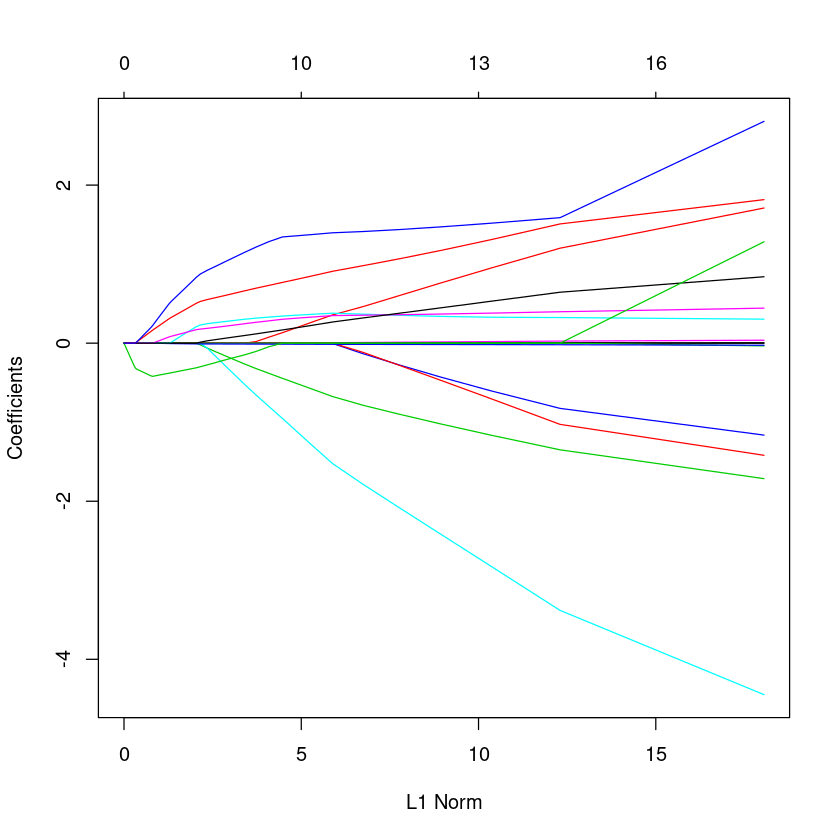

In [33]:

#plot Lasso based on deviance measure
plot(cvfit)  #note on x-axis in the plot is log(lambda), not log(1/lambda)

#plot coefficients for various models; ignore the warning message
plot(cvfit$glmnet.fit)

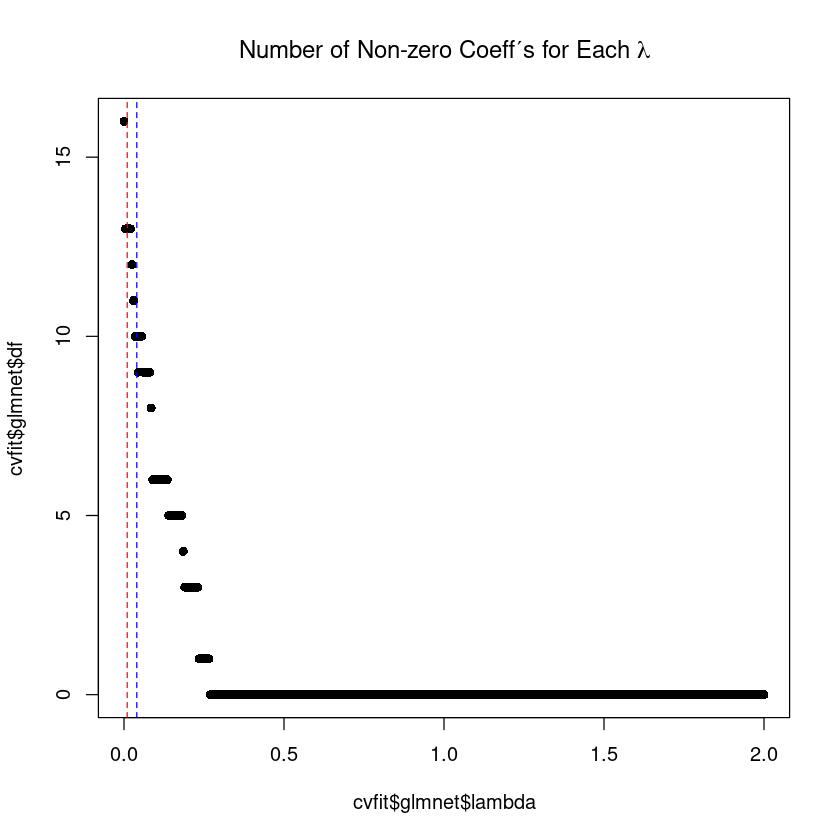

In [34]:
##Number of non-zero coefficients vs. $\lambda$

plot(cvfit$glmnet$lambda,cvfit$glmnet$df, 
     main=TeX("Number of Non-zero Coeff's for Each $\\lambda$"),pch=16)
abline(v=cvfit$lambda.min,col="red",lty="dashed")
abline(v=cvfit$lambda.1se,col="blue",lty="dashed")

### Part (c)

In this part you are to create `ytest`, `Xtest` and `pihat` from test data, similar to `y`, `X` and `pihat` that we created from train data.

Create a vector of output values from the test data, and call this vector `ytest`. Also, create matrix `Xtest`, which is the predictor matrix with predictor values from the test data.

**Hint:** `ytest` and `Xtest` should be just like `y` and `X`, except that you create them from the test data, rather than train data. The length of `ytest` should be 90, and the dimensions of `Xtest` should be 90 x 16. (since 90 is ~30% of the original cleaned data with 297 obs).

Also, create vector `pihat` using `predict()` function and the predictor values from `Xtest`. Of course, the length of `pihat` should also be 90.

In [35]:
ytest <- test$AHD
Xtest <- test[ ,!(names(test) %in% c("PatientID","AHD"))] 
Xtest <- model.matrix( ~ ., data=Xtest)[,-1]
pihat <- predict(object=cvfit, newx = Xtest, type="response")

length(ytest)
dim(Xtest)
length(pihat)

[1] 90

[1] 90 16

[1] 90

In [36]:
#check whether the lengths/dimensions of ytest, Xtest and pihat are correct

if (test_that(desc="", code={
    expect_equal(length(ytest), 90)
    }) != TRUE) stop("Sorry, wrong answer")

if (test_that(desc="", code={
    expect_equal(dim(Xtest), c(90,16))
    }) != TRUE) stop("Sorry, wrong answer")

if (test_that(desc="", code={
    expect_equal(length(pihat), 90)
    }) != TRUE) stop("Sorry, wrong answer")


Test passed 🥳
Test passed 🥇
Test passed 😸


In [37]:
#check first couple of entries for each of the three objects

if (test_that(desc="", code={
    expect_equal(all(ytest[1:7] == c('No','Yes','No','Yes','No','No','Yes')), TRUE)
    }) != TRUE) stop("Sorry, wrong answer")

if (test_that(desc="", code={
    expect_equal(all(Xtest[1:3,1:2] == matrix(c(63,1,67,1,41,0),nrow=3,byrow=TRUE)), TRUE)
    }) != TRUE) stop("Sorry, wrong answer")

if (test_that(desc="", code={
    expect_equal(norm(pihat[1:5] - c(0.186506496055056,
                                     0.928808302101098,
                                     0.176103546440831,
                                     0.41325659604545,
                                     0.387913696157712),type="2") < 1.e-5, TRUE)
    }) != TRUE) stop("Sorry, wrong answer")

Test passed 🎊
Test passed 😀
Test passed 🌈


### ROC Curve

<br>

### Part (d)

Plot the ROC curve as a visual measure of performance of your `cvfit` model on the test data. Use `roc()` function from `pROC` library. Also, create R variable `AUC` which represents AUC (area under curve), as a quantified measure of performance. (Ignore the warning message). Do NOT round your answer.

Setting levels: control = FALSE, case = TRUE

Warning message in roc.default(response = ylogical, predictor = pihat):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



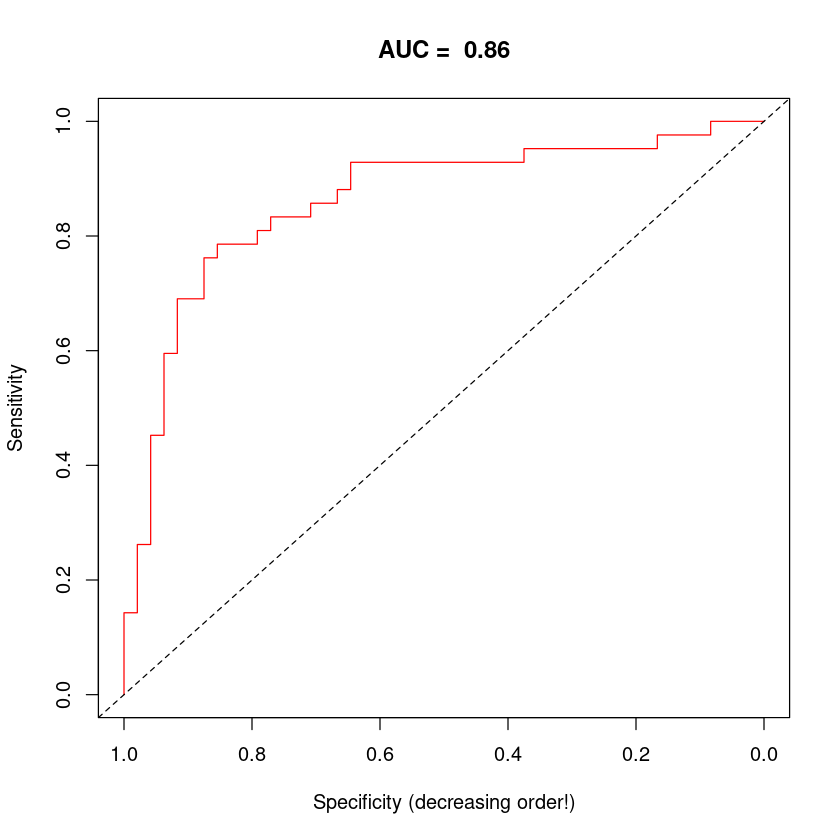

In [38]:
ylogical = (ytest == "Yes")
ROCcrv = roc(response=ylogical, predictor=pihat)
AUC = auc(ROCcrv)

plot(x=ROCcrv$specificities,y=ROCcrv$sensitivities, main=paste("AUC = ",round(AUC,2)), 
     xlab="Specificity (decreasing order!)", ylab="Sensitivity", xlim=c(1,0), type="l", col="red")
abline(a=1,b=-1,lty="dashed") 

In [39]:
#check whether the 6th and 7th decimal digits of AUC are 71

if (test_that(desc="", code={
    expect_equal(floor(AUC*10^7) %% 100 == 71, TRUE)
    }) != TRUE) stop("Sorry, wrong answer")


Test passed 🥇


In [40]:
#check whether AUC is correct (hidden tests)



### Confusion Matrix, Accuracy, False Negative Rate

<br>

### Part (d)

Create vector `yhat` of estimated (i.e. predicted) outputs $\widehat{AHD}$ for the test data, with values "Yes" if the corresponding estimated probability of "Yes" (i.e. `pihat` entry) is greater than 0.5, and "No" otherwise. 

**Hint:** this is just like we did for the train data.

Also, create R variable `tbl` which is of `table` type and represents confusion matrix, with `yhat` represented by rows and `ytest` by columns. No's should be first, followed by Yeses.

**Hint:** `tbl[2,1]` should be 6. Also, the sum of all the 4 entries should equal the sample size in the test data, which is 90.



In [41]:
yhat = ifelse(pihat>0.5,"Yes","No")
tbl = table(yhat, ytest)
tbl

     ytest
yhat  No Yes
  No  42  11
  Yes  6  31

In [42]:
#check whether first 8 values of yhat are 'No','Yes','No','No','No','No','No','Yes'

if (test_that(desc="", code={
    expect_equal(all(yhat[1:8] == c('No','Yes','No','No','No','No','No','Yes')), TRUE)
    }) != TRUE) stop("Sorry, wrong answer")

Test passed 🌈


In [43]:
#check whether yhat is correct (hiden tests)



In [44]:
#check whether tbl[2,1] is 6

if (test_that(desc="", code={
    expect_equal(tbl[2,1]==6, TRUE)
    }) != TRUE) stop("Sorry, wrong answer")

#check whether the sum of all the entries in tbl is 90

if (test_that(desc="", code={
    expect_equal(sum(tbl), 90)
    }) != TRUE) stop("Sorry, wrong answer")

Test passed 🎊
Test passed 🎉


In [45]:
#check whether tbl is correct (hidden tests)




### Part (e)

Find the accuracy, i.e. the proportion of correctly predicted outputs in the test data. Store this value in the R variable `acc`. Also, create R variable `FNR` which represents false negative rate. So, your code should be of the form 

`acc = <some expression>`

`FNR = <some expression>`

<br>

In [46]:
acc <- (tbl[1,1]+tbl[2,2])/sum(tbl)
FNR <- tbl[1,2]/sum(tbl[,2])

In [47]:
#check whether the 6th and 7th decimal digits of acc are 11

if (test_that(desc="", code={
    expect_equal(floor(acc*10^7) %% 100 == 11, TRUE)
    }) != TRUE) stop("Sorry, wrong answer")


#check whether the 6th and 7th decimal digits of FNR are 47

if (test_that(desc="", code={
    expect_equal(floor(FNR*10^7) %% 100 == 47, TRUE)
    }) != TRUE) stop("Sorry, wrong answer")


Test passed 🎉
Test passed 🥇


In [48]:
#check whether acc is correct (hidden tests)



In [49]:
#check whether FNR is correct (hidden tests)

